Epoch 0: Loss = 1.445726
Epoch 100: Loss = 0.281666
Epoch 200: Loss = 0.189100
Epoch 300: Loss = 0.138148
Epoch 400: Loss = 0.085053
Epoch 500: Loss = 0.053038
Epoch 600: Loss = 0.035497
Epoch 700: Loss = 0.024455
Epoch 800: Loss = 0.013432
Epoch 900: Loss = 0.011593


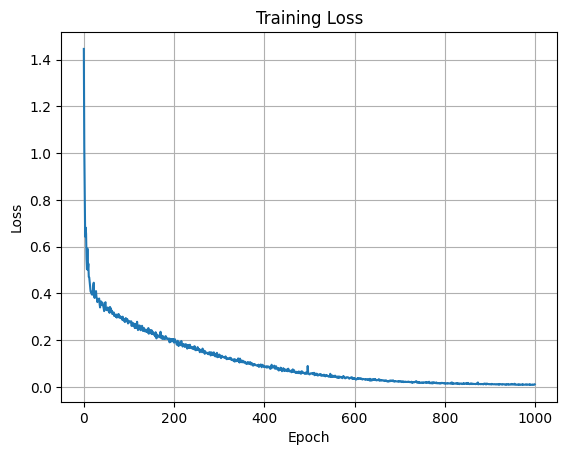

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Settings
T = 1.0
N = 40
dt = T / N
sigma = 1.0
batch_size = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Neural Networks ==========
class ZNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, x):
        inp = torch.cat([t, x], dim=1)
        return self.net(inp)

class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, x):
        inp = torch.cat([t, x], dim=1)
        return self.net(inp)

# ========== Deep BSDE ==========
class DeepBSDE_LQ(nn.Module):
    def __init__(self):
        super().__init__()
        self.Y0 = nn.Parameter(torch.tensor([[0.0]], dtype=torch.float32))
        self.z_net = ZNet().to(device)
        self.q_net = QNet().to(device)

    def forward(self):
        x = torch.ones(batch_size, 1, device=device)
        t = torch.zeros(batch_size, 1, device=device)
        Y = self.Y0.repeat(batch_size, 1)

        for _ in range(N):
            z = self.z_net(t, x)
            q = self.q_net(t, x)

            dW = torch.randn(batch_size, 1, device=device) * np.sqrt(dt)
            x = x + q * dt + sigma * dW
            f = 0.5 * q**2

            Y = Y - f * dt + z * dW
            t += dt

        terminal = 0.5 * x**2
        loss = torch.mean((Y - terminal)**2)
        return loss

# ========== Train ==========
model = DeepBSDE_LQ().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = []

for epoch in range(1000):
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


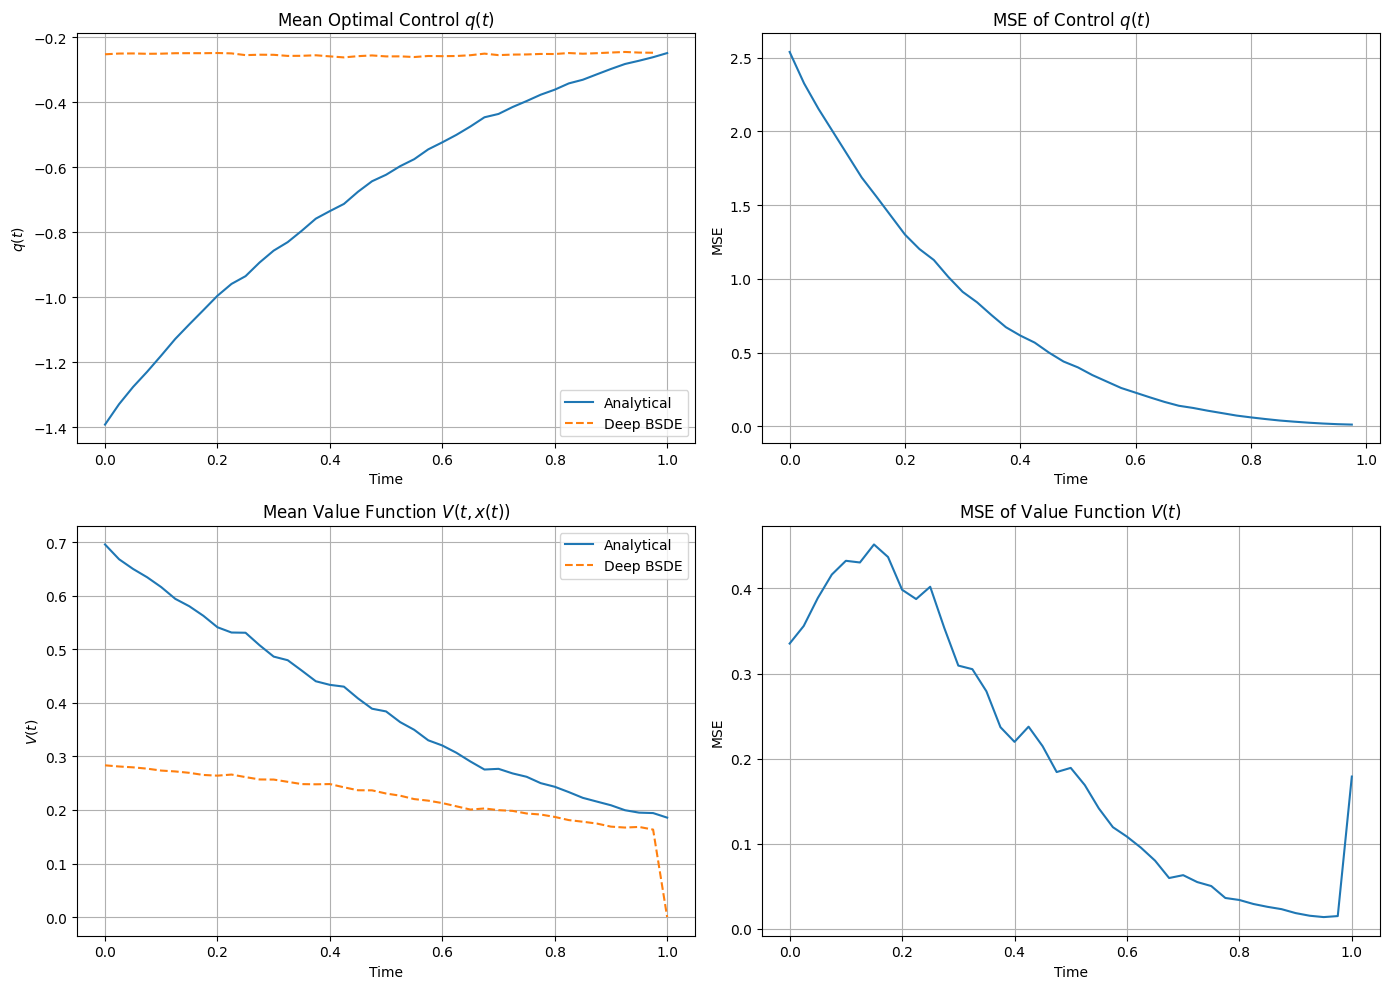

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for simulation
n_paths = 1000
t_vals = np.linspace(0, T, N + 1)
dt = T / N

# Containers for comparison
x_all = np.zeros((N + 1, n_paths))
q_nn_all = np.zeros((N + 1, n_paths))
q_true_all = np.zeros((N + 1, n_paths))
V_nn_all = np.zeros((N + 1, n_paths))
V_true_all = np.zeros((N + 1, n_paths))

# Deep BSDE components
model.eval()
with torch.no_grad():
    for i in range(n_paths // batch_size):
        x = torch.ones(batch_size, 1, device=device)
        t = torch.zeros(batch_size, 1, device=device)
        Y = model.Y0.repeat(batch_size, 1)

        for j in range(N + 1):
            idx = i * batch_size

            # Save state and predictions
            x_cpu = x.cpu().numpy().squeeze()
            x_all[j, idx:idx+batch_size] = x_cpu
            q_true_all[j, idx:idx+batch_size] = -np.exp(T - t_vals[j]) * x_cpu
            V_true_all[j, idx:idx+batch_size] = 0.5 * np.exp(T - t_vals[j]) * x_cpu**2

            if j < N:
                q = model.q_net(t, x).cpu().numpy().squeeze()
                q_nn_all[j, idx:idx+batch_size] = q
                f = 0.5 * q**2

                z = model.z_net(t, x)
                dW = torch.randn(batch_size, 1, device=device) * np.sqrt(dt)
                x = x + torch.tensor(q).view(-1, 1).to(device) * dt + sigma * dW

                Y = Y - torch.tensor(f).view(-1, 1).to(device) * dt + z * dW
                t += dt
                V_nn_all[j, idx:idx+batch_size] = Y.cpu().numpy().squeeze()

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot control comparison
axs[0, 0].plot(t_vals, q_true_all.mean(axis=1), label="Analytical")
axs[0, 0].plot(t_vals[:-1], q_nn_all[:-1].mean(axis=1), label="Deep BSDE", linestyle="--")
axs[0, 0].set_title("Mean Optimal Control $q(t)$")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("$q(t)$")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot control error
control_error = np.mean((q_nn_all[:-1] - q_true_all[:-1])**2, axis=1)
axs[0, 1].plot(t_vals[:-1], control_error)
axs[0, 1].set_title("MSE of Control $q(t)$")
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel("MSE")
axs[0, 1].grid(True)

# Plot value comparison
axs[1, 0].plot(t_vals, V_true_all.mean(axis=1), label="Analytical")
axs[1, 0].plot(t_vals, V_nn_all.mean(axis=1), label="Deep BSDE", linestyle="--")
axs[1, 0].set_title("Mean Value Function $V(t, x(t))$")
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("$V(t)$")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot value error
value_error = np.mean((V_nn_all - V_true_all)**2, axis=1)
axs[1, 1].plot(t_vals, value_error)
axs[1, 1].set_title("MSE of Value Function $V(t)$")
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("MSE")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# deep_bsde_simplehjb.py

import torch
import numpy as np
from torch import nn
from scipy.stats import multivariate_normal

# --- HJB Problem Setup ---
class SimpleHJB:
    def __init__(self, dim=1, T=1.0, N=5, lambd=1.0):
        self.dim = dim
        self.T = T
        self.N = N
        self.lambd = lambd
        self.delta_t = T / N
        self.sqrt_dt = np.sqrt(self.delta_t)
        self.x_init = np.zeros(dim)

    def sample(self, num_samples):
        dw = multivariate_normal.rvs(mean=np.zeros(self.dim),
                                      cov=np.eye(self.dim),
                                      size=(num_samples, self.N))
        if self.dim == 1:
            dw = dw.reshape(num_samples, self.N, 1)
        dw = dw.transpose(0, 2, 1) * self.sqrt_dt  # shape: [B, D, N]

        x = np.zeros((num_samples, self.dim, self.N + 1))
        x[:, :, 0] = self.x_init
        for i in range(self.N):
            x[:, :, i + 1] = x[:, :, i] + np.sqrt(2.0) * dw[:, :, i]
        return torch.FloatTensor(dw), torch.FloatTensor(x)

    def f(self, t, x, y, z):
        return -self.lambd * torch.sum(z**2, dim=1, keepdim=True)

    def g(self, x):
        return torch.log((1 + torch.sum(x**2, dim=1, keepdim=True)) / 2)


# --- Subnetwork for Z approximation ---
class SubNet(nn.Module):
    def __init__(self, dim, hidden_sizes):
        super().__init__()
        layers = []
        prev = dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# --- BSDE Solver ---
class DeepBSDE(nn.Module):
    def __init__(self, eqn, hidden_sizes=[64, 64]):
        super().__init__()
        self.eqn = eqn
        self.y0 = nn.Parameter(torch.tensor([-0.1]))
        self.z0 = nn.Parameter(torch.zeros((1, eqn.dim)))  # learnable initial control
        self.z_nets = nn.ModuleList([SubNet(eqn.dim, hidden_sizes) for _ in range(eqn.N - 1)])

    def forward(self, x, dw):
        batch_size = x.size(0)
        y = self.y0.expand(batch_size, 1)
        loss = 0.0

        for i in range(self.eqn.N):
            t_i = i * self.eqn.delta_t
            x_i = x[:, :, i]
            dw_i = dw[:, :, i]
            
            if i == 0:
                z = self.z0.expand(batch_size, -1)
            else:
                z = self.z_nets[i - 1](x_i)
            
            # Forward one step
            y_next = y - self.eqn.delta_t * self.eqn.f(t_i, x_i, y, z) + torch.sum(z * dw_i, dim=1, keepdim=True)

            # Residual: what should have happened vs. what did
            if i < self.eqn.N - 1:
                x_next = x[:, :, i + 1]
                if i == self.eqn.N - 2:
                    z_next = self.z_nets[i](x_next)
                else:
                    z_next = self.z_nets[i](x_next).detach()
                phi = -self.eqn.f(t_i, x_i, y, z)
                sigma = np.sqrt(2.0)
                bsde_residual = y_next - y - phi * self.eqn.delta_t - torch.sum(z * dw_i, dim=1, keepdim=True)
                loss += torch.mean(bsde_residual**2)

            y = y_next  # update y

        # Terminal loss
        y_terminal = y
        g_terminal = self.eqn.g(x[:, :, -1])
        loss += nn.MSELoss()(y_terminal, g_terminal)

        return loss, self.y0


# --- Training Script ---
def analytical_solution(x=0.0, T=1.0, lambd=1.0, num_samples=100000):
    W_T = np.random.normal(loc=0.0, scale=np.sqrt(T), size=num_samples)
    X_T = x + np.sqrt(2.0) * W_T
    g_X_T = np.log((1 + X_T**2) / 2)
    exp_val = np.mean(np.exp(-lambd * g_X_T))
    return -1.0 / lambd * np.log(exp_val)


def train_bsde():
    eqn = SimpleHJB(dim=1, T=1.0, N=20, lambd=1.0)
    model = DeepBSDE(eqn).to("cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1000):
        dw, x = eqn.sample(64)
        optimizer.zero_grad()
        loss, y0 = model(x, dw)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}, y0 = {y0.item():.6f}")

    print(f"\nFinal Approximation of u(0, x0): {model.y0.item():.6f}")
    u_analytical = analytical_solution(x=0.0, T=1.0, lambd=1.0)
    print(f"Analytical u(0, 0): {u_analytical:.6f}")
    print(f"Absolute error: {abs(model.y0.item() - u_analytical):.6f}")


if __name__ == "__main__":
    train_bsde()

Epoch 0: Loss = 0.467378, y0 = -0.099000
Epoch 100: Loss = 0.025646, y0 = -0.111224
Epoch 200: Loss = 0.017286, y0 = -0.157918
Epoch 300: Loss = 0.013796, y0 = -0.190233
Epoch 400: Loss = 0.016726, y0 = -0.204457
Epoch 500: Loss = 0.015347, y0 = -0.212968
Epoch 600: Loss = 0.016490, y0 = -0.212969
Epoch 700: Loss = 0.016001, y0 = -0.214968
Epoch 800: Loss = 0.018827, y0 = -0.214154
Epoch 900: Loss = 0.016155, y0 = -0.215724

Final Approximation of u(0, x0): -0.216867
Analytical u(0, 0): -0.084468
Absolute error: 0.132398
